[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/havelhakimi/gene-expression/blob/main/RNA_Seq_PANCAN_dataset.ipynb)


# **About dataset**

This collection of data is part of the RNA-Seq (HiSeq) PANCAN data set, it is a random extraction of gene expressions of patients having different types of tumor:
* BRCA:Breast invasive carcinoma
* KIRC:Kidney renal clear cell carcinoma
* COAD:Colon adenocarcinoma
* LUAD:Lung adenocarcinoma
* PRAD:Prostate adenocarcinoma
</br>Data availabe at : https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq

**Data Set Information:**
Samples (instances) are stored row-wise. Variables (attributes) of each sample are RNA-Seq gene expression levels measured by illumina HiSeq platform</br>
**Attribute information:**
A dummy name (gene_XX) is given to each attribute

In [1]:
# downloading the dataset and unzip it
!wget -O data.tar.gz \
https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz
!gunzip data.tar.gz
!tar -xvf data.tar

--2025-04-05 12:08:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.tar.gz’

data.tar.gz             [        <=>         ]  69.48M  45.0MB/s    in 1.5s    

2025-04-05 12:08:04 (45.0 MB/s) - ‘data.tar.gz’ saved [72856320]

TCGA-PANCAN-HiSeq-801x20531/
TCGA-PANCAN-HiSeq-801x20531/data.csv
TCGA-PANCAN-HiSeq-801x20531/labels.csv


In [2]:
#import all necessary libraries
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import warnings
from scipy import cluster
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics,datasets
warnings.filterwarnings('ignore')

In [3]:
# load the the tumor dataset
tumor_data = pd.read_csv('./TCGA-PANCAN-HiSeq-801x20531/data.csv',index_col=0)
# load the corresponding labels
labels=pd.read_csv('./TCGA-PANCAN-HiSeq-801x20531/labels.csv', index_col=0)
#concatenating the labels of ecah sample along with its features
tumor_data['Tumor Label']=labels

In [4]:
# Print the dataframe
tumor_data.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,Tumor Label
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0,PRAD
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0,LUAD
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0,PRAD
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0,PRAD
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0,BRCA


In [5]:
# Total null values in each column
tumor_data.isna().sum()

,0
gene_0,0
gene_1,0
gene_2,0
gene_3,0
gene_4,0
...,...
gene_20527,0
gene_20528,0
gene_20529,0
gene_20530,0


In [6]:
print(f'Duplicate rows in the datsaset :{tumor_data.duplicated().sum()}\n')

Duplicate rows in the datsaset :0



In [7]:
#extracting feature columns from the tumor dataframe
feature_cols_tumor=tumor_data.columns.tolist()[:-1]


In [8]:

# Mapping each tumor label to integer numbers
tumor_map={'PRAD':0,'LUAD':1,'BRCA':2,'KIRC':3,'COAD':4}
# Creating a new column which contains classno
tumor_data['classno']= labels['Class'].map(tumor_map)


# **Hierarchical clustering**
The two main categories of Hierarchical clustering are:
1. Divisive clustering
2. Agglomerative clustering

* Agglomerative clustering is much more popular than divisive clustering due to the fact that we are usually given a set of data points at the start of the clustering process. Hence the easiest way to form cluster is to keep merging similar points into clusters repeatedly.
* Divisive clustering is always more complex because it is very difficult to decide the basis of dividing the dataset into clusters.

# **Proximity measures**
* Generally the euclidean distance is used as a distance measure for computing the closeness of data points in agglomerative clustering. However there are other proximity measures like 'manhattan' and 'cosine' which can be used to measure cluster distances.


* There are different ways for representing distance between clusters i.e. by using different forms of linkages like single, complete, group average etc.

* Throughout the question 3, we have used the euclidean distance as the proximity measure.



# **Preparing a dataframe to store tsne results which will help later in visulaization**

In [9]:
from sklearn.manifold import TSNE


#Performing tsne on the dataset which will help in cluster visualization
tsne = TSNE(n_components = 2, random_state = 0)
tsne_euc = tsne.fit_transform(tumor_data[feature_cols_tumor])
tumor_labels= tumor_data['classno']
tumor_labels=np.array(tumor_labels).reshape(-1,1)


# creating a new tsne dataframe which help us in plotting the given class labels and resulting cluster later on
tsne_data = np.concatenate((tsne_euc, tumor_labels), axis=1)
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("Dim_1", "Dim_2", "Tumor Label"))


# **Using Single Linkage**


## **dendrogram visualisation**

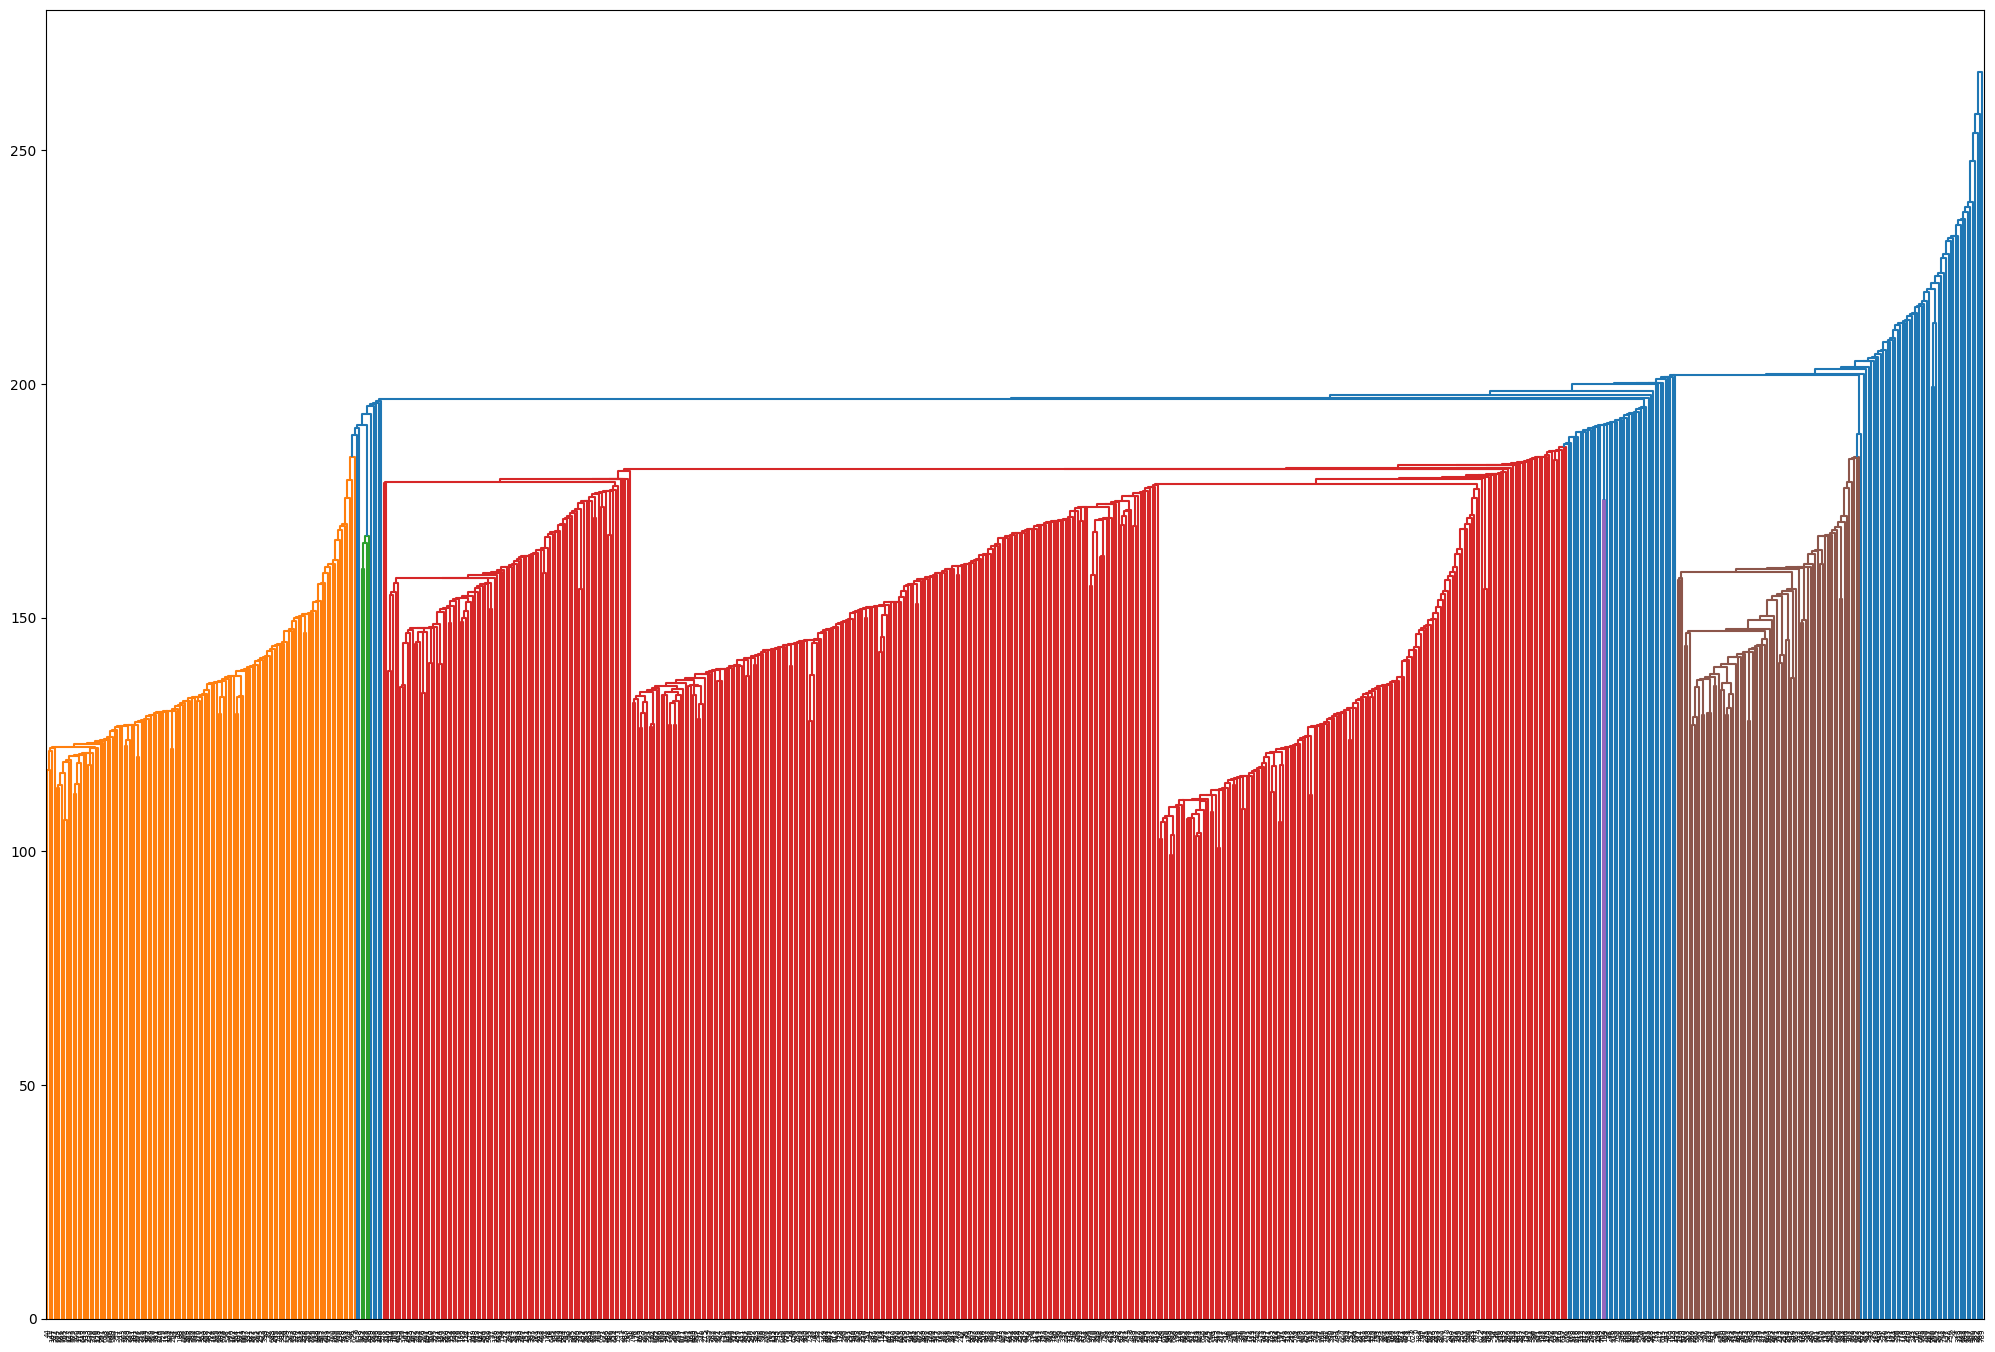

In [10]:
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance


#calculating pairwise distance
eucl_dist_spy = distance.pdist(tumor_data[feature_cols_tumor], metric='euclidean')
# performing agglomerative clustering
single_linkage = linkage(eucl_dist_spy, 'single')
# Plot Dendrotram
plt.figure(figsize=(25, 17))
dendrogram(single_linkage,
            orientation='top',
            #labels = tumor_data[feature_cols].index,
            distance_sort='descending', show_leaf_counts=True,
            )
plt.show()

## **Observations from single linkage dendrogram tree**
* Its a very cluttered dendrogram.
* Dendrogram indicates that the single linkage doesn't represent the notion of hierarchy properly.

## **Single linkage based Agglomerative  Clustering**

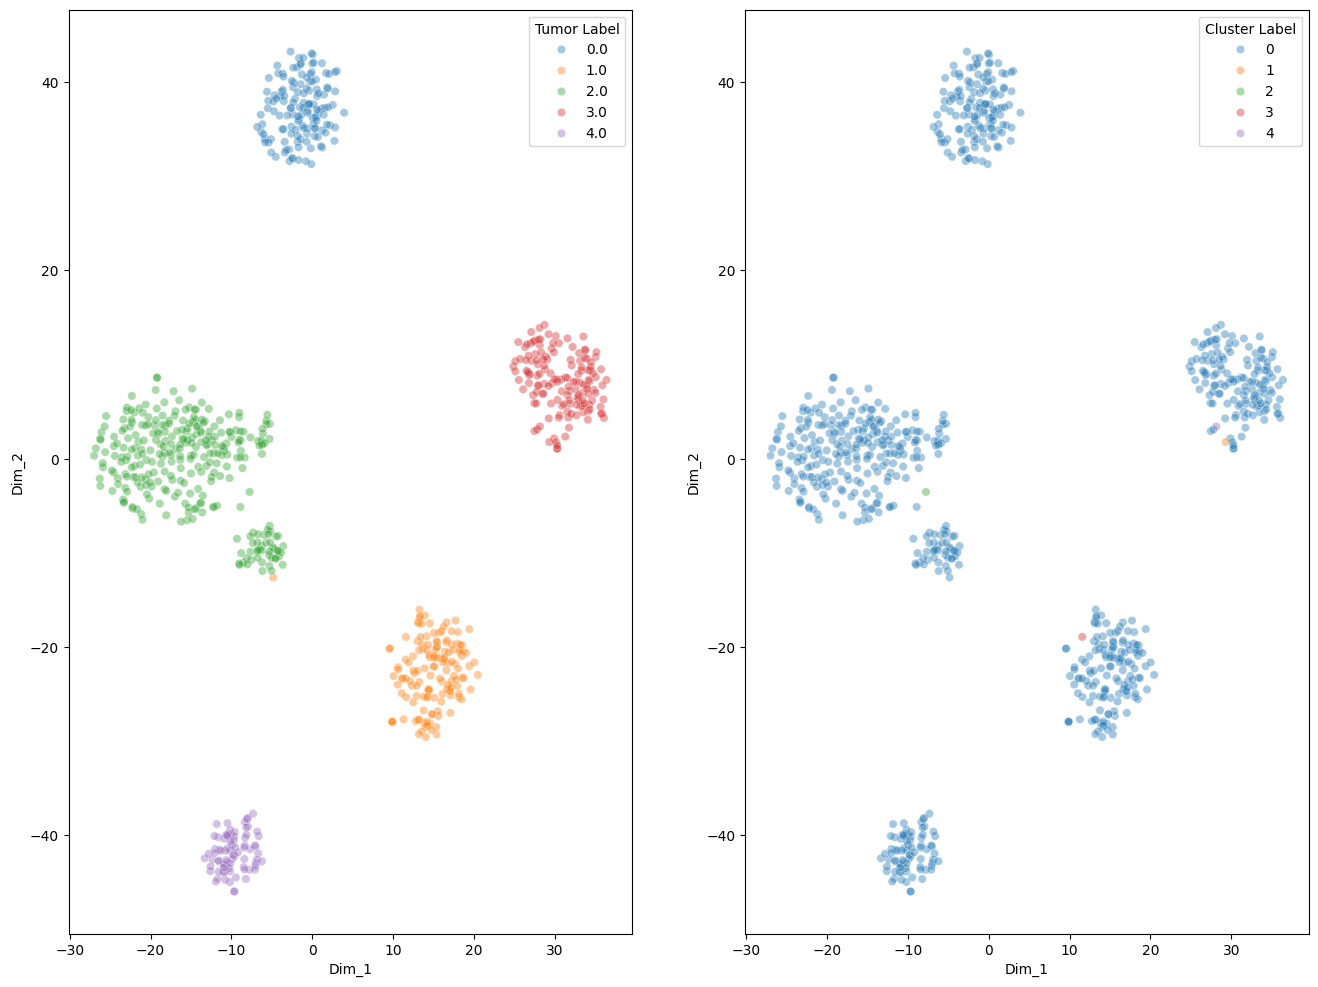

Intrinsic Measure:

Silhouette score: 0.080
Calinski and Harabasz score: 1.714
Davies-Bouldin score: 0.770

Extrinsic Measure:

Random index: 0.247
Completeness score: 0.200
Random index Adjusated for Chance: 0.000
Adjusted Mutual Information between two clusterings: 0.000


In [11]:
from scipy import cluster

import sklearn.metrics.pairwise as smp


# Performing Hierarchical clustering by cutting the dendogram to obtain 5 clusters.

cluster_labels = cluster.hierarchy.cut_tree(single_linkage, n_clusters=5)

# creating a sepaarte tsne variable to store single linkage results
tsne_df_single=tsne_df.copy()

tsne_df_single['Cluster Label']=cluster_labels




# Relevant code for plotting the given class labels and cluster labels
colors = sns.color_palette()

modes_gt=tsne_df_single['Tumor Label'].unique()
palette_gt = {mode: color for mode, color in zip(modes_gt, colors)}

modes_clus=tsne_df_single['Cluster Label'].unique()
palette_clus = {mode: color for mode, color in zip(modes_clus, colors)}

plt.figure(figsize = (16, 12))
ax = plt.subplot(1,2,1)
sns.scatterplot(x="Dim_1", y="Dim_2", data=tsne_df_single, ax= ax,hue='Tumor Label',palette=palette_gt,alpha=0.4);
ax = plt.subplot(1,2,2)
sns.scatterplot(x="Dim_1", y="Dim_2", data=tsne_df_single, ax= ax, hue='Cluster Label',palette=palette_clus,alpha=0.4);
plt.show()


# calculating performance metrics for sklearn

#pairwise_dist_sk = smp.euclidean_distances(tumor_data[feature_cols_tumor])

# calculating intrinsic measures : silhouette score, Calinski and Harabasz score and davies bouldin score
#SIL_s=metrics.silhouette_score(pairwise_dist_sk , cluster_labels)
#CH_s=metrics.calinski_harabasz_score(pairwise_dist_sk , cluster_labels)
#DB_s=metrics.davies_bouldin_score(pairwise_dist_sk , cluster_labels)

SIL_s=metrics.silhouette_score(tumor_data[feature_cols_tumor] , cluster_labels)
CH_s=metrics.calinski_harabasz_score(tumor_data[feature_cols_tumor] , cluster_labels)
DB_s=metrics.davies_bouldin_score(tumor_data[feature_cols_tumor] , cluster_labels)


y_true=tumor_data['classno'].tolist()
y_pred=np.array(cluster_labels).reshape(-1)

# calculating extrinsic measures: rand index and completeness
RI_s=metrics.rand_score(y_true,y_pred)
CM_s=metrics.completeness_score(y_true,y_pred)
ARI_ward = metrics.adjusted_rand_score(y_true,y_pred)
AMI_ward=metrics.adjusted_mutual_info_score(y_true,y_pred)

print('Intrinsic Measure:\n')
print(f'Silhouette score: {SIL_s:.3f}')
print(f'Calinski and Harabasz score: {CH_s:.3f}')
print(f'Davies-Bouldin score: {DB_s:.3f}')
print('')
print('Extrinsic Measure:\n')

print(f'Random index: {RI_s:.3f}')
print(f'Completeness score: {CM_s:.3f}')
print(f'Random index Adjusated for Chance: {ARI_ward:.3f}')
print(f'Adjusted Mutual Information between two clusterings: {AMI_ward:.3f}')


###  Standard behaviour of the cluster validity indices used
* The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
* The minimum value for Davies-Bouldin score is 0, with lower values indicating better clustering.
* The higher the Calinski and Harabasz score , the better the performances.
* The Rand Index may only yield a value between 0 and 1 with higher value indicating better clustering.

* Completeness Score is a value between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.

## **Observations from Single linkage based Agglomerative  Clustering**
* It can be seen from visual comparison that single linkage performs very poor agglomerative clustering on dataset 2.
* Also the performance of all cluster validity indices is quite poor for single linkage based agglomerative clustering


# **Using Complete Linkage**





## **dendrogram visualisation**

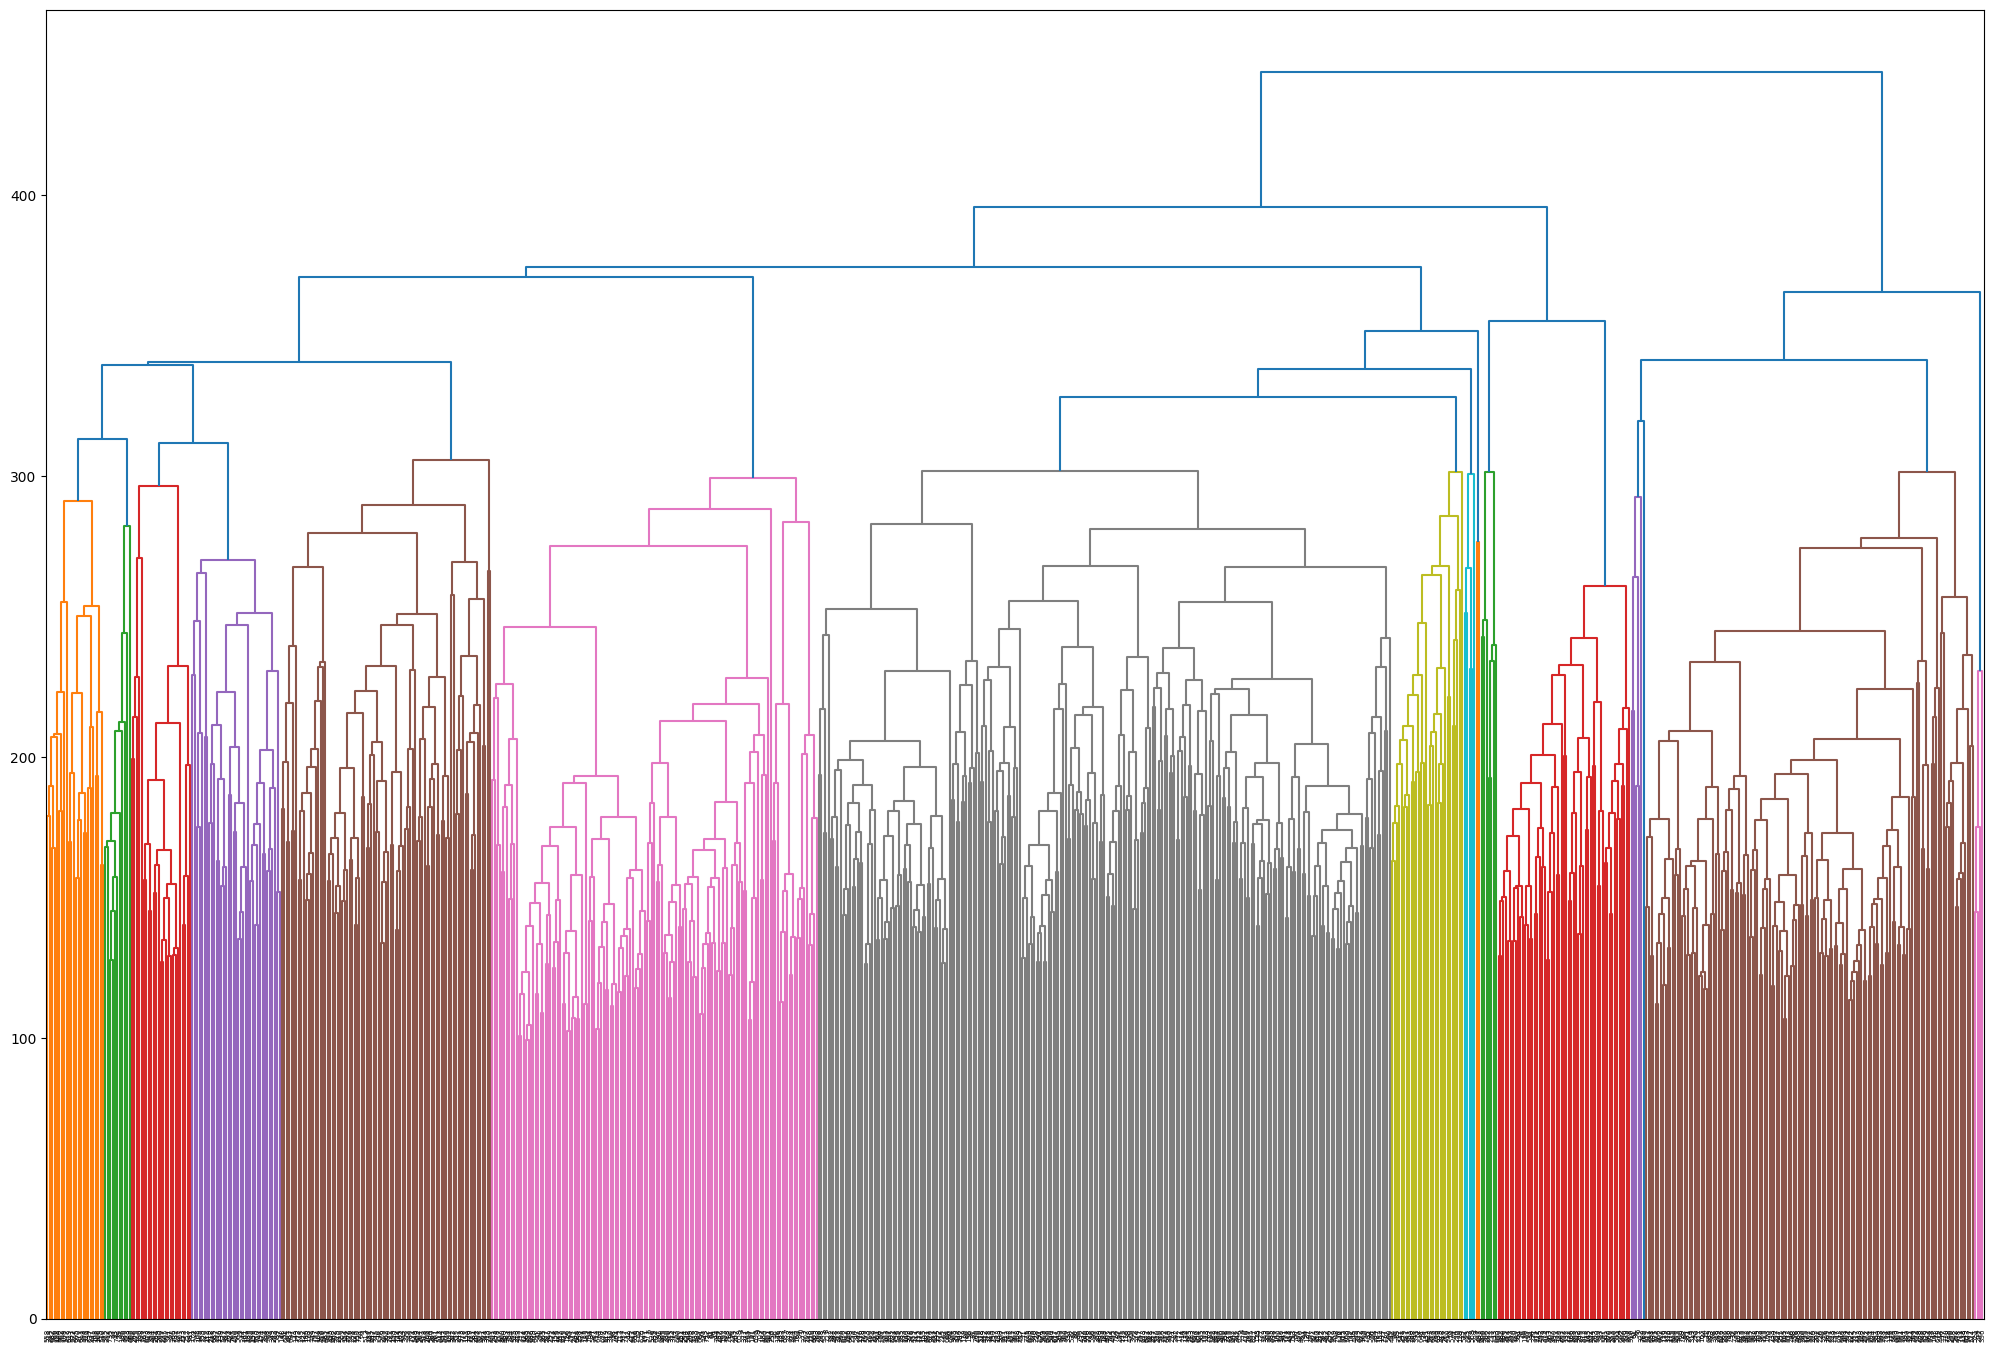

In [12]:
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance


#calculating pairwise distance
eucl_dist_spy = distance.pdist(tumor_data[feature_cols_tumor], metric='euclidean')
# performing agglomerative clustering
comp_linkage = linkage(eucl_dist_spy, 'complete')
# Plot Dendrotram
plt.figure(figsize=(25, 17))
dendrogram(comp_linkage,
            orientation='top',
            #labels = tumor_data[feature_cols].index,
            distance_sort='descending', show_leaf_counts=True,
            )
plt.show()

## **Observations from complete linkage dendrogram tree**
* Much better dendrogram than single linkage but still slightly cluttered.
* However the clusters at each level as per dendrogram are still not very well separated from each other.





## **Complete linkage based Agglomerative  Clustering**

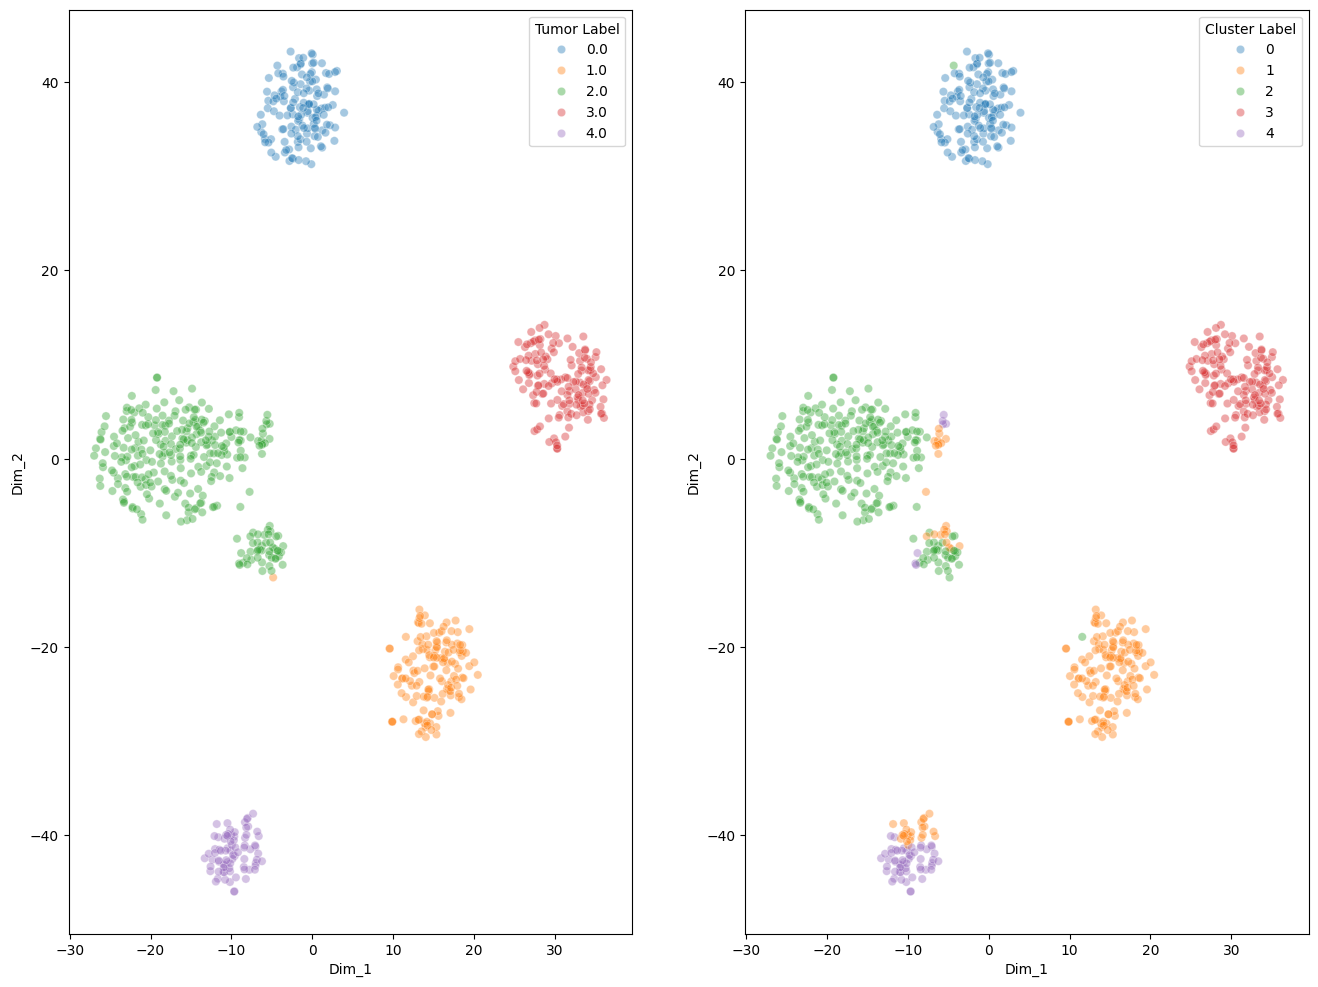

Intrinsic Measure:

Silhouette score: 0.202
Calinski and Harabasz score: 113.604
Davies-Bouldin score: 2.012

Extrinsic Measure:

Random index: 0.945
Completeness score: 0.856
Random index Adjusated for Chance: 0.849
Adjusted Mutual Information between two clusterings: 0.855


In [13]:
from scipy import cluster
import seaborn as sns

import seaborn as sns
import sklearn.metrics.pairwise as smp


# Performing Hierarchical clustering by cutting the dendogram to obtain 5 clusters.

cluster_labels = cluster.hierarchy.cut_tree(comp_linkage, n_clusters=5)

# creating a sepaarte tsne variable to store  linkage results
tsne_df_comp=tsne_df.copy()

tsne_df_comp['Cluster Label']=cluster_labels




# visualising tsne plots of the data using class labels and cluster labels
colors = sns.color_palette()

modes_gt=tsne_df_single['Tumor Label'].unique()
palette_gt = {mode: color for mode, color in zip(modes_gt, colors)}

modes_clus=tsne_df_single['Cluster Label'].unique()
palette_clus = {mode: color for mode, color in zip(modes_clus, colors)}

plt.figure(figsize = (16, 12))
ax = plt.subplot(1,2,1)
sns.scatterplot(x="Dim_1", y="Dim_2", data=tsne_df_comp, ax= ax,hue='Tumor Label',palette=palette_gt,alpha=0.4);
ax = plt.subplot(1,2,2)
sns.scatterplot(x="Dim_1", y="Dim_2", data=tsne_df_comp, ax= ax, hue='Cluster Label',palette=palette_clus,alpha=0.4);
plt.show()


# calculating performance metrics for sklearn

#pairwise_dist_sk = smp.euclidean_distances(tumor_data[feature_cols_tumor])

# calculating intrinsic measures : silhouette score, Calinski and Harabasz score and davies bouldin score
#SIL_s=metrics.silhouette_score(pairwise_dist_sk , cluster_labels)
#CH_s=metrics.calinski_harabasz_score(pairwise_dist_sk , cluster_labels)
#DB_s=metrics.davies_bouldin_score(pairwise_dist_sk , cluster_labels)

SIL_s=metrics.silhouette_score(tumor_data[feature_cols_tumor] , cluster_labels)
CH_s=metrics.calinski_harabasz_score(tumor_data[feature_cols_tumor] , cluster_labels)
DB_s=metrics.davies_bouldin_score(tumor_data[feature_cols_tumor] , cluster_labels)


y_true=tumor_data['classno'].tolist()
y_pred=np.array(cluster_labels).reshape(-1)

# calculating extrinsic measures: rand index and completeness
RI_s=metrics.rand_score(y_true,y_pred)
CM_s=metrics.completeness_score(y_true,y_pred)
ARI_ward = metrics.adjusted_rand_score(y_true,y_pred)
AMI_ward=metrics.adjusted_mutual_info_score(y_true,y_pred)

print('Intrinsic Measure:\n')
print(f'Silhouette score: {SIL_s:.3f}')
print(f'Calinski and Harabasz score: {CH_s:.3f}')
print(f'Davies-Bouldin score: {DB_s:.3f}')
print('')
print('Extrinsic Measure:\n')

print(f'Random index: {RI_s:.3f}')
print(f'Completeness score: {CM_s:.3f}')
print(f'Random index Adjusated for Chance: {ARI_ward:.3f}')
print(f'Adjusted Mutual Information between two clusterings: {AMI_ward:.3f}')


###  Standard behaviour of the cluster validity indices used
* The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
* The minimum value for Davies-Bouldin score is 0, with lower values indicating better clustering.
* The higher the Calinski and Harabasz score , the better the performances.
* The Rand Index may only yield a value between 0 and 1 with higher value indicating better clustering.

* Completeness Score is a value between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.

## **Observations from Complete linkage based Agglomerative  Clustering**

* It can be seen from visual comparison that complete linkage is able to partition the data into 5 distinct clusters much better than single linkage.
* There are few notable errors in cluster labelling but overall there is huge similarity between the cluster labels and the given labels.
* Also the performance of all cluster validity indices is good for complete linkage based agglomerative clustering


# **Using Group Average**

## **dendrogram visualisation**

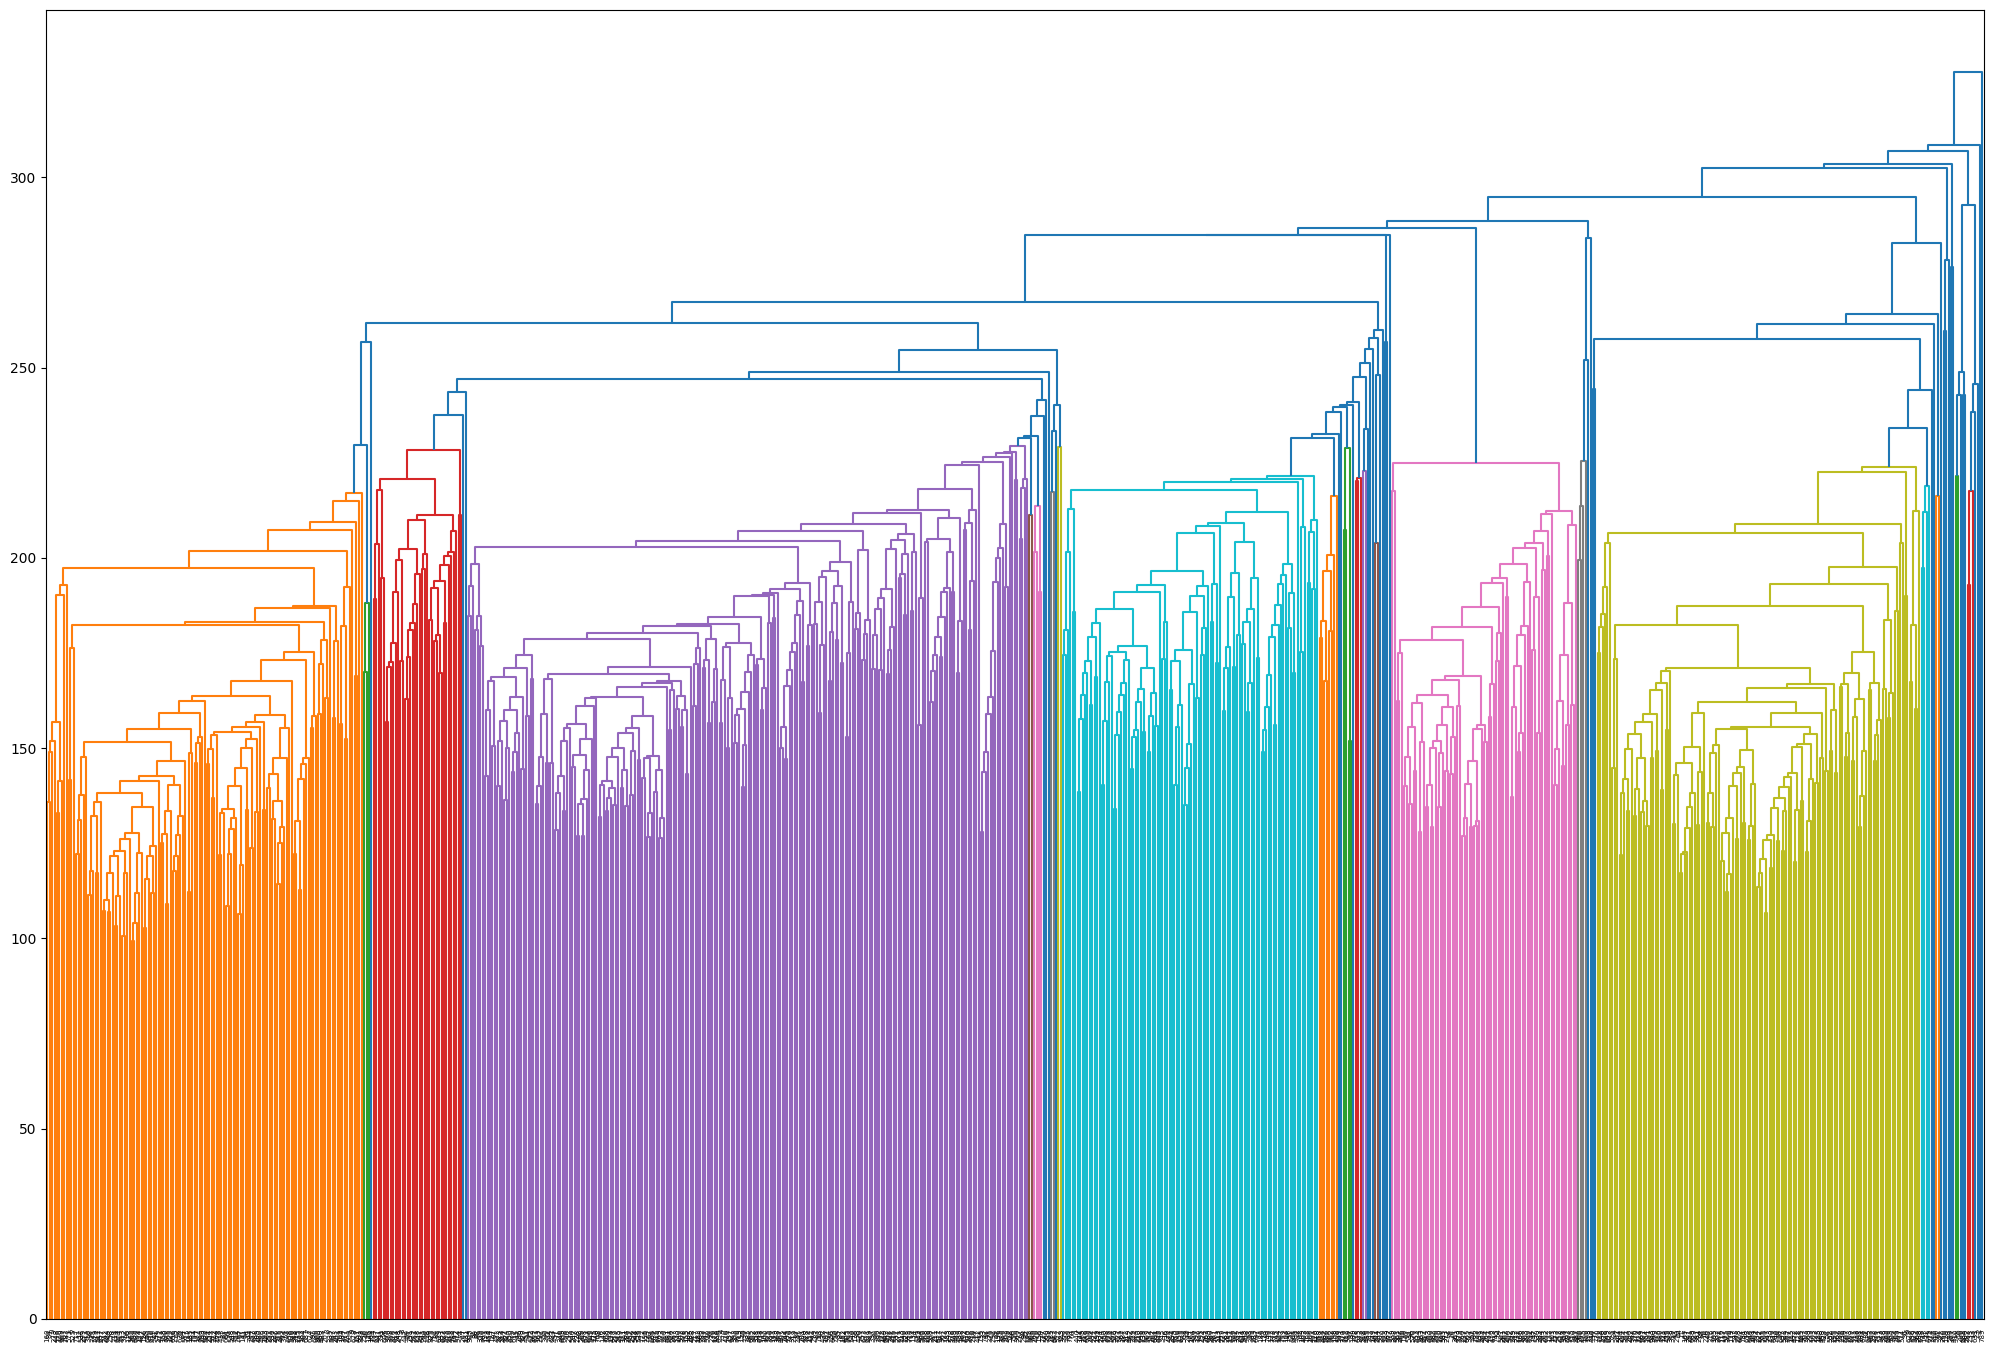

In [14]:
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance


#calculating pairwise distance
eucl_dist_spy = distance.pdist(tumor_data[feature_cols_tumor], metric='euclidean')
# performing agglomerative clustering
avg_linkage = linkage(eucl_dist_spy, 'average')
# Plot Dendrotram for Hirarchical Clustering
plt.figure(figsize=(25, 17))
dendrogram(avg_linkage,
            orientation='top',
            #labels = tumor_data[feature_cols].index,
            distance_sort='descending', show_leaf_counts=True,
            )
plt.show()

## **Observations from group average dendrogram tree**
* The dendrogram tree is very cluttered.
* The group average dendrogram is worse than the complete linkage and completely ignores the hierarchy existing in the dataset.
* The dendrogram goodness can be given as :
  * Complete Linkage > Group Average > Single Linkage




## **Group average based Agglomerative  Clustering**

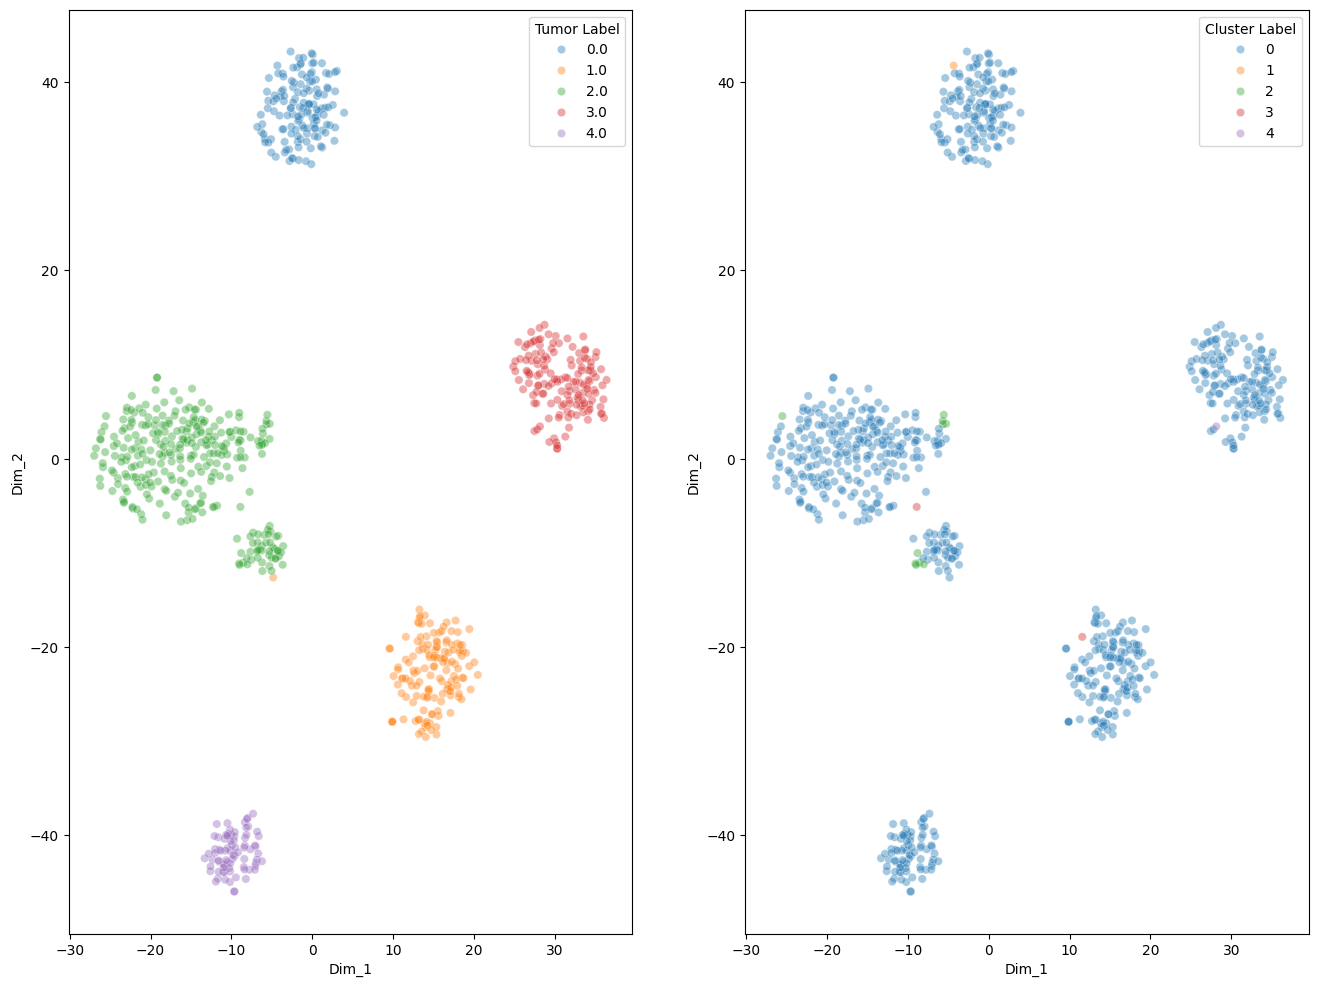

Intrinsic Measure:

Silhouette score: 0.078
Calinski and Harabasz score: 3.263
Davies-Bouldin score: 1.535

Extrinsic Measure:

Random index: 0.254
Completeness score: 0.177
Random index Adjusated for Chance: -0.008
Adjusted Mutual Information between two clusterings: 0.012


In [15]:
from scipy import cluster
import seaborn as sns

import seaborn as sns
import sklearn.metrics.pairwise as smp


# Performing Hierarchical clustering by cutting the dendogram to obtain 5 clusters.

cluster_labels = cluster.hierarchy.cut_tree(avg_linkage, n_clusters=5)

# creating a sepaarte tsne variable to store  linkage results
tsne_df_avg=tsne_df.copy()

tsne_df_avg['Cluster Label']=cluster_labels





# visualising tsne plots of the data using class labels and cluster labels
colors = sns.color_palette()

modes_gt=tsne_df_avg['Tumor Label'].unique()
palette_gt = {mode: color for mode, color in zip(modes_gt, colors)}

modes_clus=tsne_df_avg['Cluster Label'].unique()
palette_clus = {mode: color for mode, color in zip(modes_clus, colors)}

plt.figure(figsize = (16, 12))
ax = plt.subplot(1,2,1)
sns.scatterplot(x="Dim_1", y="Dim_2", data=tsne_df_avg, ax= ax,hue='Tumor Label',palette=palette_gt,alpha=0.4);
ax = plt.subplot(1,2,2)
sns.scatterplot(x="Dim_1", y="Dim_2", data=tsne_df_avg, ax= ax, hue='Cluster Label',palette=palette_clus,alpha=0.4);
plt.show()


# calculating performance metrics for sklearn

#pairwise_dist_sk = smp.euclidean_distances(tumor_data[feature_cols_tumor])

# calculating intrinsic measures : silhouette score, Calinski and Harabasz score and davies bouldin score
#SIL_s=metrics.silhouette_score(pairwise_dist_sk , cluster_labels)
#CH_s=metrics.calinski_harabasz_score(pairwise_dist_sk , cluster_labels)
#DB_s=metrics.davies_bouldin_score(pairwise_dist_sk , cluster_labels)

SIL_s=metrics.silhouette_score(tumor_data[feature_cols_tumor] , cluster_labels)
CH_s=metrics.calinski_harabasz_score(tumor_data[feature_cols_tumor] , cluster_labels)
DB_s=metrics.davies_bouldin_score(tumor_data[feature_cols_tumor] , cluster_labels)


y_true=tumor_data['classno'].tolist()
y_pred=np.array(cluster_labels).reshape(-1)

# calculating extrinsic measures: rand index and completeness
RI_s=metrics.rand_score(y_true,y_pred)
CM_s=metrics.completeness_score(y_true,y_pred)
ARI_ward = metrics.adjusted_rand_score(y_true,y_pred)
AMI_ward=metrics.adjusted_mutual_info_score(y_true,y_pred)

print('Intrinsic Measure:\n')
print(f'Silhouette score: {SIL_s:.3f}')
print(f'Calinski and Harabasz score: {CH_s:.3f}')
print(f'Davies-Bouldin score: {DB_s:.3f}')
print('')
print('Extrinsic Measure:\n')

print(f'Random index: {RI_s:.3f}')
print(f'Completeness score: {CM_s:.3f}')
print(f'Random index Adjusated for Chance: {ARI_ward:.3f}')
print(f'Adjusted Mutual Information between two clusterings: {AMI_ward:.3f}')


###  Standard behaviour of the cluster validity indices used
* The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
* The minimum value for Davies-Bouldin score is 0, with lower values indicating better clustering.
* The higher the Calinski and Harabasz score , the better the performances.
* The Rand Index may only yield a value between 0 and 1 with higher value indicating better clustering.

* Completeness Score is a value between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.

## **Observations from Group average based Agglomerative  Clustering**



* It can be seen from visual comparison that group average performs very poor clustering.
* Group average shows poor performance for all of the clustering validity indices.




# **Using Minimum variance**


## **dendrogram visualisation**

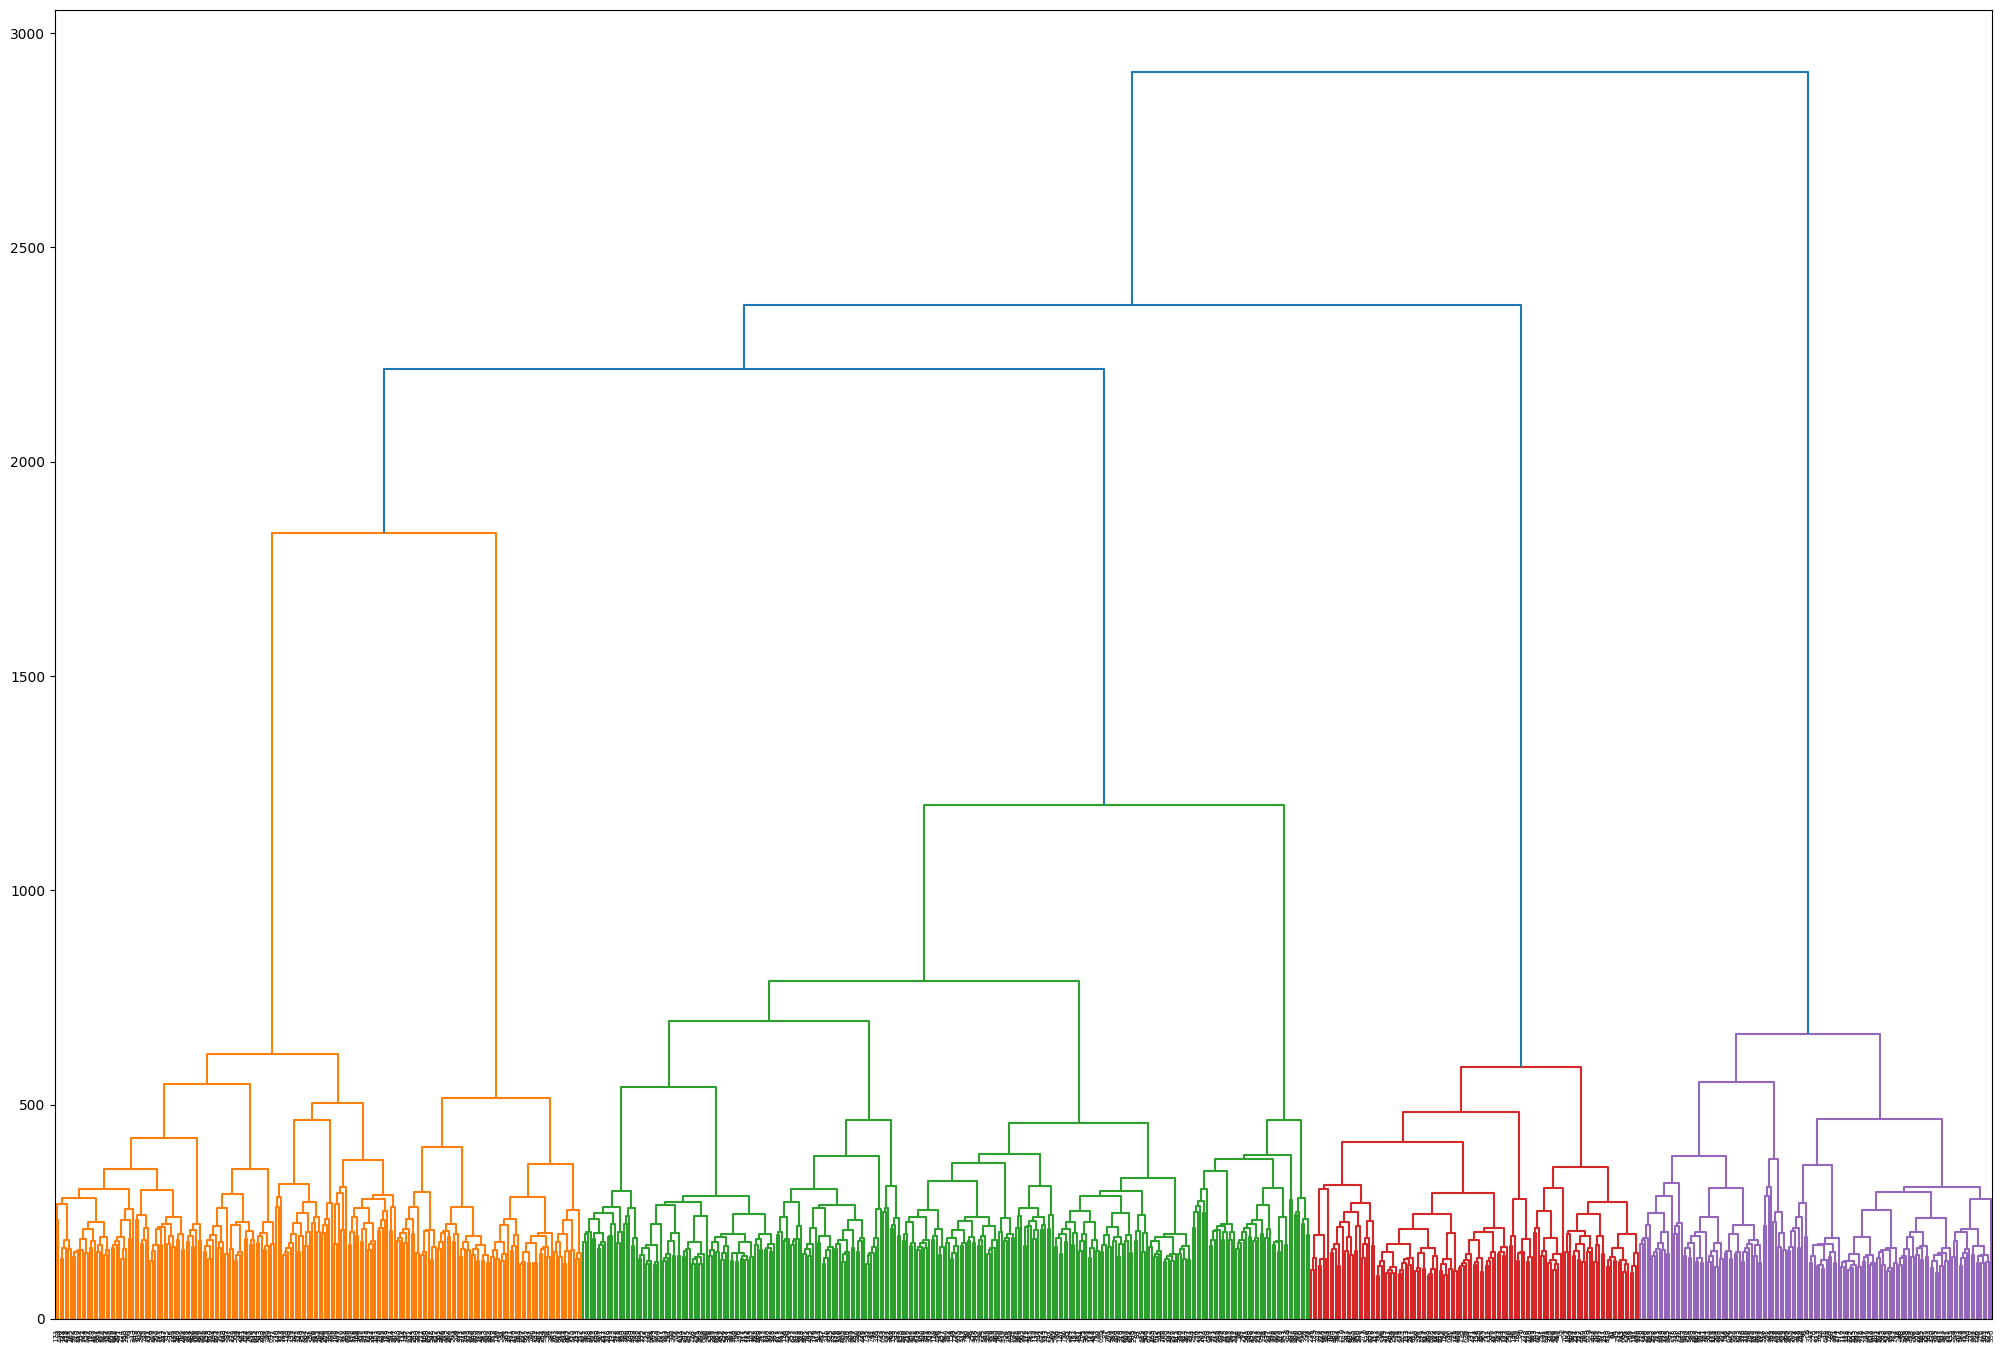

In [16]:

from sklearn.metrics import pairwise_distances
from scipy.spatial import distance


#calculating pairwise distance
eucl_dist_spy = distance.pdist(tumor_data[feature_cols_tumor], metric='euclidean')
# performing agglomerative clustering
wardlinkage = linkage(eucl_dist_spy, 'ward')
# Plot Dendrotram for Hirarchical Clustering
plt.figure(figsize=(25, 17))
dendrogram(wardlinkage,
            orientation='top',
            #labels = tumor_data[feature_cols].index,
            distance_sort='descending', show_leaf_counts=True,
            )
plt.show()

# Observations from minimum variance dendrogram tree

* Minimum variance based dendrogram shows well separated clusters.
* The dendrogram goodness can be given as :
  * Minimum variance > Complete Linkage > Group Average > Single Linkage
* The performance is best among all the linkages.
* It seems it has very well preserved the notion of hierarchy which we assumed in the tumor dataset (dataset 2).





# **Minimum variance based Agglomerative  Clustering**


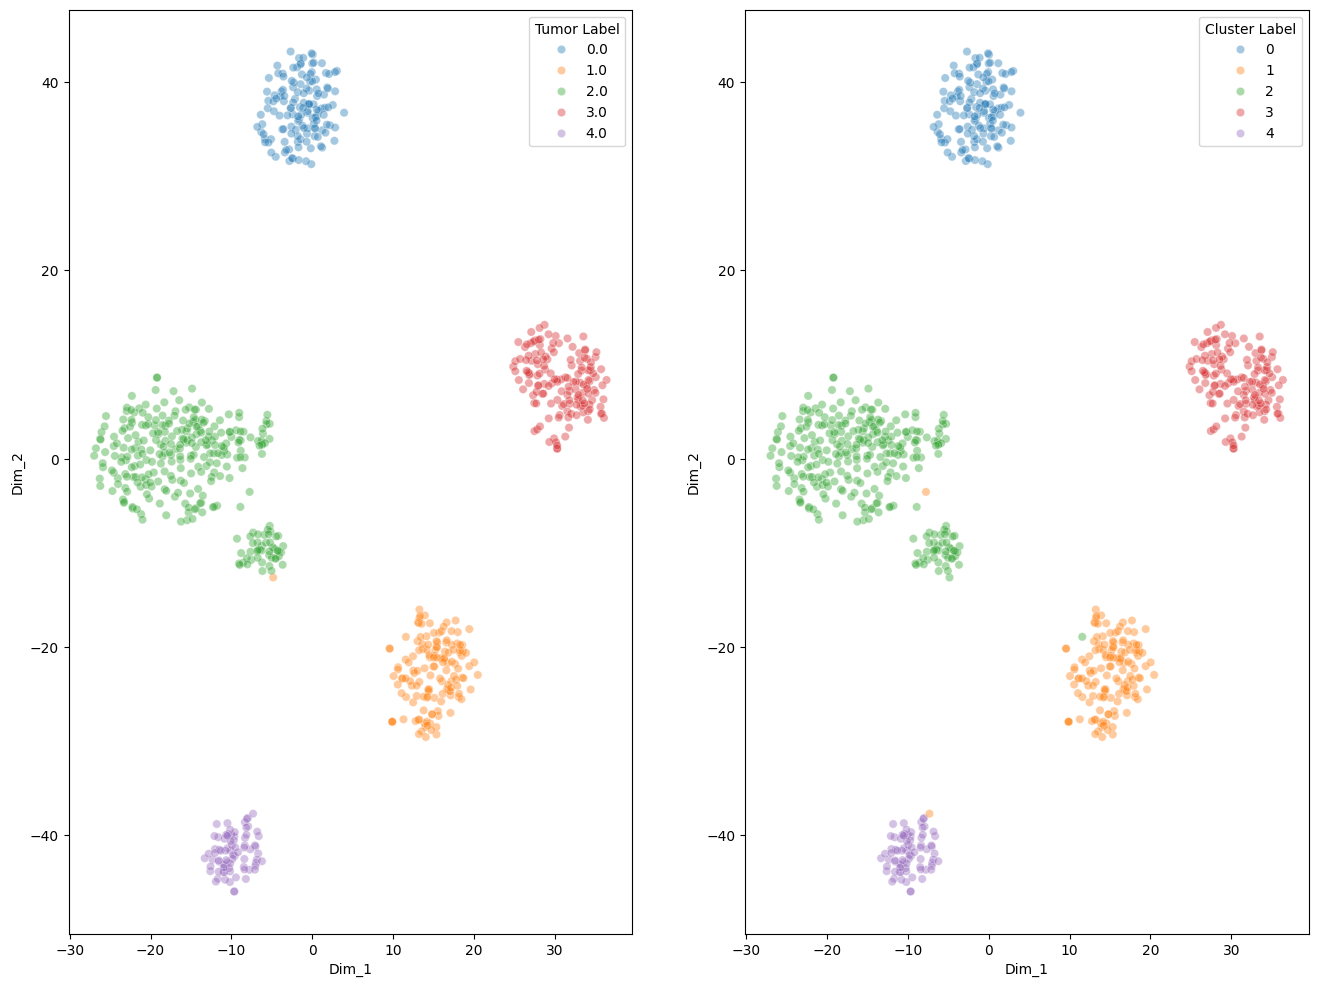

Intrinsic Measure:

Silhouette score: 0.225
Calinski and Harabasz score: 124.797
Davies-Bouldin score: 1.831

Extrinsic Measure:

Random index: 0.254
Completeness score: 0.177
Random index Adjusated for Chance: -0.008
Adjusted Mutual Information between two clusterings: 0.012


In [19]:
from scipy import cluster
import seaborn as sns

import seaborn as sns
import sklearn.metrics.pairwise as smp


# Performing Hierarchical clustering by cutting the dendogram to obtain 5 clusters.

cluster_labels = cluster.hierarchy.cut_tree(wardlinkage, n_clusters=5)

# creating a sepaarte tsne variable to store linkage results
tsne_df_ward=tsne_df.copy()

tsne_df_ward['Cluster Label']=cluster_labels



# visualising tsne plots of the data using class labels and cluster labels
colors = sns.color_palette()

modes_gt=tsne_df_ward['Tumor Label'].unique()
palette_gt = {mode: color for mode, color in zip(modes_gt, colors)}

modes_clus=tsne_df_ward['Cluster Label'].unique()
palette_clus = {mode: color for mode, color in zip(modes_clus, colors)}

plt.figure(figsize = (16, 12))
ax = plt.subplot(1,2,1)
sns.scatterplot(x="Dim_1", y="Dim_2", data=tsne_df_ward, ax= ax,hue='Tumor Label',palette=palette_gt,alpha=0.4);
ax = plt.subplot(1,2,2)
sns.scatterplot(x="Dim_1", y="Dim_2", data=tsne_df_ward, ax= ax, hue='Cluster Label',palette=palette_clus,alpha=0.4);
plt.show()


# calculating performance metrics for sklearn

#pairwise_dist_sk = smp.euclidean_distances(tumor_data[feature_cols_tumor])

# calculating intrinsic measures : silhouette score, Calinski and Harabasz score and davies bouldin score
#SIL_s=metrics.silhouette_score(pairwise_dist_sk , cluster_labels)
#CH_s=metrics.calinski_harabasz_score(pairwise_dist_sk , cluster_labels)
#DB_s=metrics.davies_bouldin_score(pairwise_dist_sk , cluster_labels)

SIL_s=metrics.silhouette_score(tumor_data[feature_cols_tumor] , cluster_labels)
CH_s=metrics.calinski_harabasz_score(tumor_data[feature_cols_tumor] , cluster_labels)
DB_s=metrics.davies_bouldin_score(tumor_data[feature_cols_tumor] , cluster_labels)


# calculating extrinsic measures: rand index and completeness
RI_s=metrics.rand_score(y_true,y_pred)
CM_s=metrics.completeness_score(y_true,y_pred)
ARI_ward = metrics.adjusted_rand_score(y_true,y_pred)
AMI_ward=metrics.adjusted_mutual_info_score(y_true,y_pred)

print('Intrinsic Measure:\n')
print(f'Silhouette score: {SIL_s:.3f}')
print(f'Calinski and Harabasz score: {CH_s:.3f}')
print(f'Davies-Bouldin score: {DB_s:.3f}')
print('')
print('Extrinsic Measure:\n')

print(f'Random index: {RI_s:.3f}')
print(f'Completeness score: {CM_s:.3f}')
print(f'Random index Adjusated for Chance: {ARI_ward:.3f}')
print(f'Adjusted Mutual Information between two clusterings: {AMI_ward:.3f}')


###  Standard behaviour of the cluster validity indices used
* The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
* The minimum value for Davies-Bouldin score is 0, with lower values indicating better clustering.
* The higher the Calinski and Harabasz score , the better the performances.
* The Rand Index may only yield a value between 0 and 1 with higher value indicating better clustering.

* Completeness Score is a value between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.

## **Observations from Minimum Variance based Agglomerative  Clustering**
* The clusters obtained via minimum variance are almost similar to the given class labels.
* Also the performance of all cluster validity indices is very good for minimum varaince based agglomerative clustering


# **Final Observations**

* The intrinsic validation indices are giving good results for Minimum Variance and Complete linkage.
* The extrinsic validation indices are giving very good results for Minimum Variance and Complete linkage.
* Minimum Variance based dendrogram shows well separated clusters and preserves the notion of hierarchy which we assumed in this dataset.
* It can be concluded that agglomerative based methods (minimum variance ) perform very well on this dataset.

